# Modeling School-Age Population Decline and the Cooperation among Schools
Daeil Chun, 2022-02-01

### Introduction
The agents in this model represent the colleges in a region where population declines, e.g. as in Korea. Government and public opinion recommend each school to restructure their business operation either by reducing the number of entering students or merging with other schools. They recommend this because a sudden closure of schools increases some social costs on job market, land use efficiency and student welfares. However, regardless of public recommendation, the schools, who are free agents, can stick to their current business operation, hoping they can sustain themselves with the remaining students after other schools exit the market. So, each school is modeled either to cooperate to the policy recommendation or defect it.




### Why ABM
- Good to model the two levels of analysis: individual agents and public outcome
- Good to model the abstract distance among competing schools: either geographical or subject(major)-wise distance
- Simulate several times to predict with statistical inference

### Key Assumptions
- A little change from Prisoner's Dilema Utility {d, c} > {c,c} > {d, d} > {c, d} to {d, c} > {c,c} > {c, d} > {d, d} to make {d,d} the worst. 
- Simulteneous game: all decide next moves without knowing what others choose
- Evolutionary game: imitate the best neighbor (the richest)'s past move
- Torodial space: as pacman game
- reference: John Epstine, NetLogo, Python MESA, etc.



### How the Game Proceed
1. Each school begins with an initial score randomly chosen from a range (e.g. between 0 to 20).
2. Each school scans the 8 neighbors' current scores and one's own score, and determin the best neighbor, i.e. the one having the highest in the scores.
3. Each school determines the next move by immitating the best neighbor's current move.
4. Advance to the next step with the chosen move.
5. Play the game with all 8 neighbors, and sum up all the payoffs to add on one's own score.
6. Repeat the 2 ~ 5 in every step
7. If current score is negative, go bankrupt




### Payoff Matrix
The left side is my move. The payoff is the same to all. 

#### Literature History of the model
Epstein's - A standard prisoner's dilema
<table>
    <tr><td></td><td>Cooperate</td><td>Defect</td></tr>
    <tr><td>Cooperate</td><td>5,5</td><td>-6,6</td></tr>
    <tr><td>Defect</td><td>6,-6</td><td>-5,-5</td></tr>
</table>


Wilensky's NetLogo Application
<table>
    <tr><td></td><td>Cooperate</td><td>Defect</td></tr>
    <tr><td>Cooperate</td><td>1,1</td><td>0, alpha</td></tr>
    <tr><td>Defect</td><td>alpha, 0</td><td>0,0</td></tr>
</table>


#### My model
<table>
    <tr><td></td><td>Cooperate</td><td>Defect</td><td>Bankrupt</td></tr>
    <tr><td>Cooperate</td><td>portion*A</td><td>portion*B</td><td>0</td></tr>
    <tr><td>Defect</td><td>portion*C</td><td>portion*D</td><td>0</td></tr>
    <tr><td>Bankrupt</td><td>0</td><td>0</td><td>0</td></tr>
</table>

- portion = the population / the number of agents (changing every step)
- {C, C} : When all ideally cooperate, the equal portion will be returned to everyone. (e.g. set A = 1)
- {C, D} : When others defect, I stil gain but relatively smaller than {C. C}. (e.g. set B=0.5). This is a change from Prisoner's Dilema, which makes it the worst. For my model, coopertion or defect is about downsizing the school operation, so it can avoid the worst even when others defect.
- {D, C} : When only I defect, I gain relatively greater than {C, C}. (e.g. set C = 1.5)
- {D, D} : When all compete regardless of population decline, all should share the penalty. (e.g. set D = -1)
- Playing against/by bankrupt agents are like void, returning zero. Note that, in the model, bankrupt agents still occupy their locations, being a social cost of land inefficiency.

### A Sample Outcome
For this notebook analysis, an outcome of any specified step will be displayed as the following:

![alt text](sampleimage.JPG "Sample Output")


- Red cells: defecting agent
- Blue cells: cooperating agents
- white cells: bankrupt agents


### Codes
Since this codes will be modified later for server implementation, one can skip to Simulation sections far below.

In [1]:
# Define model parameters
# For now, they are all set as 1 or 0 for now to compile the funtions in the jupyter notebook.
# These will be re-configured before running the model each time.

ppl = 1             # the initial population
ppl_change = 1      # the population change rate in each step 
schools = 1         # the initial number of schools
init_score_min = 1   # for the randmon assignment of initial scores for each agent 
init_score_max = 1   # for the randmon assignment of initial scores for each agent
payoff_coeff = [1, 1, 1, 1]    # the payoff matrix will take these
payoff_mtx = {("C", "C"): ppl/schools*payoff_coeff[0], ("C", "D"): ppl/schools*payoff_coeff[1], ("D", "C"): ppl/schools*payoff_coeff[2], ("D", "D"): ppl/schools*payoff_coeff[3], ("B", "B"): 0, ("B", "C"): 0, ("B", "D"): 0, ("C", "B"): 0, ("D", "B"): 0}
init_coop = 1   # the proportion of cooperating schools at the beginning, between 0~1


#### Base Classes
The codes are modified from the pd_grid model built in MESA. The following Model and Agent classes would better be separated from the notebook, but, for now, they are modified here.

In [2]:
# agent.py

from mesa import Agent


class PDAgent(Agent):
    """Agent member of the iterated, spatial prisoner's dilemma model."""

    def __init__(self, pos, model, starting_move=None):
        """
        Create a new Prisoner's Dilemma agent.

        Args:
            pos: (x, y) tuple of the agent's position.
            model: model instance
            starting_move: If provided, determines the agent's initial state:
                           C(ooperating) or D(efecting). Otherwise, random.
        """
        super().__init__(pos, model)
        self.pos = pos

        # Schools differ in their initial assets to endure population decline.
        self.score = self.random.randint(init_score_min, init_score_max)

        if starting_move:
            self.move = starting_move
        else:
            self.move = self.random.choice(["C", "D"])
        self.next_move = None

    @property
    def isCooroperating(self):
        return self.move == "C"

    def step(self):
        """Get the neighbors' moves, and change own move accordingly."""

        neighbors = self.model.grid.get_neighbors(self.pos, True, include_center=True)
        best_neighbor = max(neighbors, key=lambda a: a.score)
        self.next_move = best_neighbor.move

        if self.score < 0:
            self.next_move = "B"

        if self.model.schedule_type != "Simultaneous":
            self.advance()

    def advance(self):
        self.move = self.next_move
        self.score += self.increment_score()

    def increment_score(self):
        neighbors = self.model.grid.get_neighbors(self.pos, True)
        if self.model.schedule_type == "Simultaneous":
            moves = [neighbor.next_move for neighbor in neighbors]
        else:
            moves = [neighbor.move for neighbor in neighbors]
        return sum(self.model.payoff[(self.move, move)] for move in moves)


In [3]:
# model.py

from mesa import Model
from mesa.time import BaseScheduler, RandomActivation, SimultaneousActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

#from .agent import PDAgent <--recover later when using a server

# test for weighted random move. note model.py already import random.
import random

class PdGrid(Model):
    """Model class for iterated, spatial prisoner's dilemma model for school consolidation."""

    schedule_types = {
        "Sequential": BaseScheduler,
        "Random": RandomActivation,
        "Simultaneous": SimultaneousActivation,
    }

    # payoff matrix with empty value
    payoff = payoff_mtx
    population = ppl

    def __init__(
        self, height=50, width=50, schedule_type="Simultaneous", payoffs=None, seed=None
    ):
        """
        Create a new Spatial Prisoners' Dilemma Model.

        Args:
            height, width: Grid size. There will be one agent per grid cell.
            schedule_type: Can be "Sequential", "Random", or "Simultaneous".
                           Determines the agent activation regime.
            payoffs: (optional) Dictionary of (move, neighbor_move) payoffs.
        """
        
        self.grid = SingleGrid(width, height, torus=True)
        self.schedule_type = schedule_type
        self.schedule = self.schedule_types[self.schedule_type](self)

        # Create agents
        for x in range(width):
            for y in range(height):

                # Weighted random assignment for the initial move of each agent
                init_move = random.choices(population=["C", "D"], weights=[init_coop, 1-init_coop], k=1)[0] # to get the number out of list
                
                agent = PDAgent((x, y), self, init_move)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)

        self.datacollector = DataCollector(
            {
                "Cooperating Schools": lambda m: len(
                    [a for a in m.schedule.agents if a.move == "C"]
                )
            }
        )

        #test
        self.datacollector2 = DataCollector(
            {
                "Bankrupt Schools": lambda m: len(
                    [a for a in m.schedule.agents if a.score < 0]
                )
            }
        )


        self.running = True
        self.datacollector.collect(self)
        self.datacollector2.collect(self)

    def step(self, n):
        self.population = self.population*ppl_change
        #self.alive_schools = schools - self.datacollector2.collect(self)
        self.payoff = payoff_mtx # redo with new population
        self.schedule.step()

        # collect data
        self.datacollector.collect(self)
        self.datacollector2.collect(self)
        


    def run(self, n):
        """Run the model for n steps."""
        for _ in range(n):
            self.step(n)



#### Plot functions

The following code will be later modified for web application with user input.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec
%matplotlib inline

In [5]:
bwr = plt.get_cmap("bwr")

def draw_grid(model, ax=None):
    '''
    Draw the current state of the grid, with Defecting agents in red
    and Cooperating agents in blue.
    '''
    if not ax:
        fig, ax = plt.subplots(figsize=(6,6))
    grid = np.zeros((model.grid.width, model.grid.height))
    for agent, x, y in model.grid.coord_iter():
        if agent.score < 0:
            grid[y][x] = 0.5
        elif agent.move == "D":
            grid[y][x] = 1
        else:
            grid[y][x] = 0
    ax.pcolormesh(grid, cmap=bwr, vmin=0, vmax=1)
    ax.axis('off')
    ax.set_title("Steps: {}".format(model.schedule.steps))

In [6]:
def run_model(model):
    '''
    Run an experiment with a given model, and plot the results.
    '''
    fig = plt.figure(figsize=(12,12))
    
    for i in range(1,10):
        ax = fig.add_subplot(3,3, i)
        draw_grid(model, ax)
        model.run(5) # specify the step
        
    # draw_grid(model, ax2)
    # model.run(1)
    # draw_grid(model, ax3)

    model.datacollector.get_model_vars_dataframe().plot()
    model.datacollector2.get_model_vars_dataframe().plot()
    

In [7]:
# Set the random seed
seed = 12

### Simulations
#### 1. Model Parameters

Throughout the simulations, I am going to use the following parameters unchanged.

In [8]:
# model parameters

ppl = 1000          # The initial population
ppl_change = -0.01  # Decline 1% every step 
schools = 50*50     # 2500 schools in total
init_score_min = 10     # Agents at least begin with 10 score
init_score_max = 100    # Agents at best begin with 100 score
payoff_coeff = [1, 0.5, 1.5, -1]    # See the above Payoff matrix section
payoff_mtx = {("C", "C"): ppl/schools*payoff_coeff[0], ("C", "D"): ppl/schools*payoff_coeff[1], ("D", "C"): ppl/schools*payoff_coeff[2], ("D", "D"): ppl/schools*payoff_coeff[3], ("B", "B"): 0, ("B", "C"): 0, ("B", "D"): 0, ("C", "B"): 0, ("D", "B"): 0}


My main question is to see how the initial number of cooperating schools can lead different outcomes later. So, I will change the following parameter every simulation.

In [9]:
init_coop = 0 # the proportion of cooperating schools (between 0~1) at the beginning

#### 2. Some sanity checks of the model
Following two simulations are rather a test for the model's robustness with extreme values.

##### 2.1 When all defect at the beginning

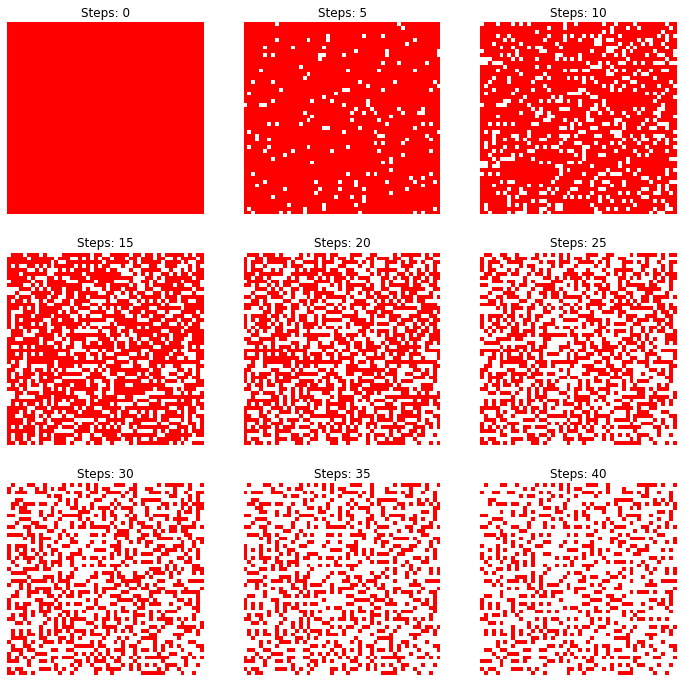

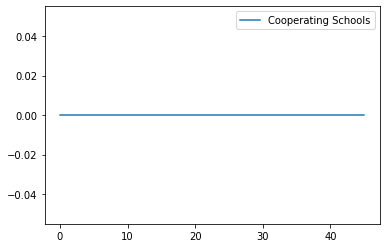

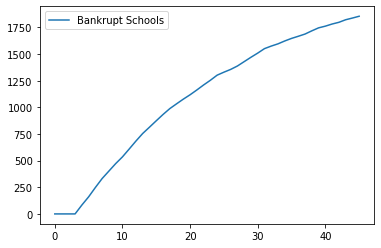

In [10]:
# Set the model parameters 

init_coop = 0 # the proportion of cooperating schools at step 0

# run the mobel
m = PdGrid(50, 50, "Simultaneous")
run_model(m)

When all defect, schools gradually go bankrupt. In 40 steps, the bankrupts are more than 1750.

#### 2.2 When all cooperate at the beginning

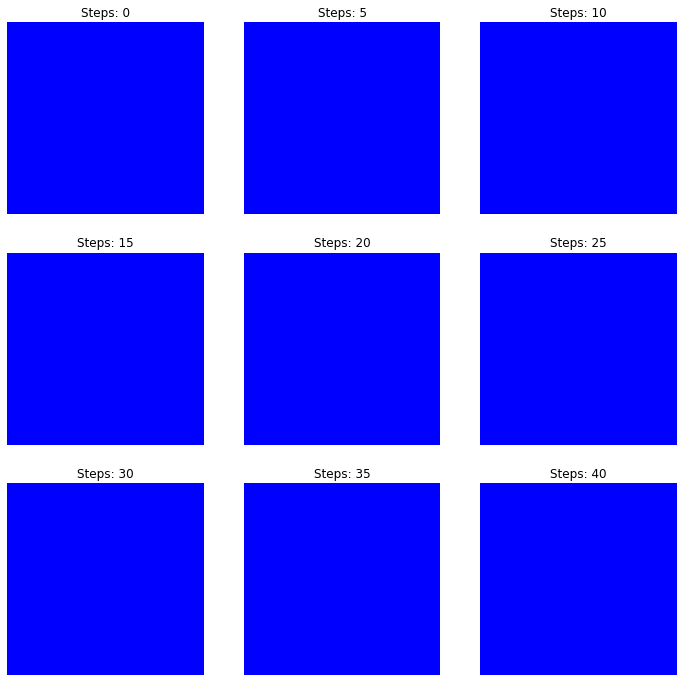

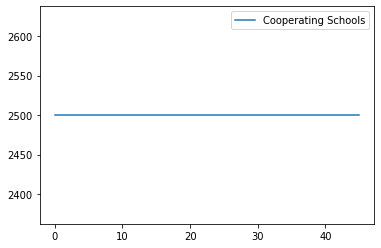

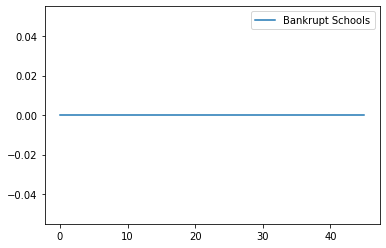

In [11]:
# Set the model parameters 

init_coop = 1 # the proportion of cooperating schools at step 0

# run the mobel
m = PdGrid(50, 50, "Simultaneous")
run_model(m)

As expected, when all begin with cooperation, they equally share the impact of the population decline together. So, nobody go bankrupt.

### 3. When 5% cooperate at the beginning

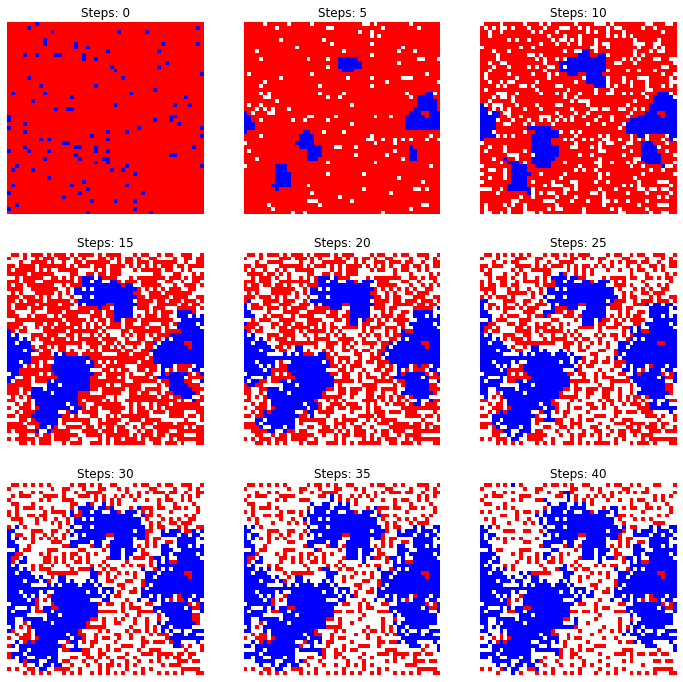

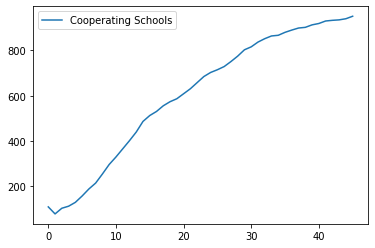

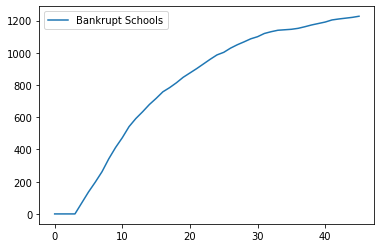

In [12]:
# Set the model parameters 

init_coop = 0.05 # the proportion of cooperating schools at step 0

# run the mobel
m = PdGrid()
run_model(m)

In this particular run, only 5% of cooperating schools at the beginning could reduce the bankrupt schools about 50% of all defect scenario. For more running, see the batch simulation section below.

### 3. When 10% cooperate at the beginning

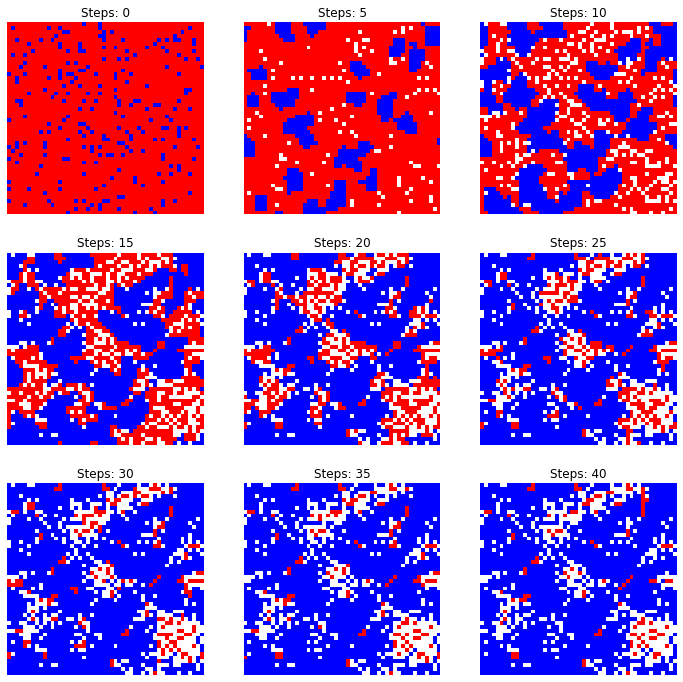

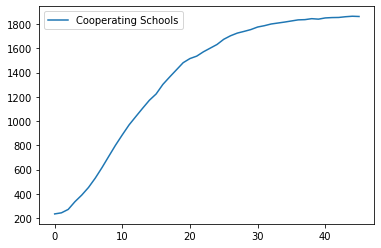

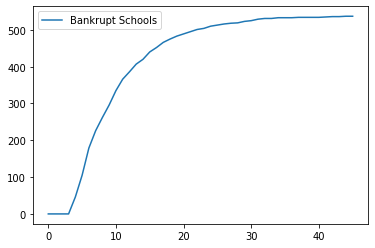

In [13]:
# Set the model parameters 
init_coop = 0.1 # the proportion of cooperating schools at step 0

# run the mobel
m = PdGrid(50, 50, "Simultaneous")
run_model(m)

In this particular run, 10% cooperating at the beginning, the bankrupts could be reduced 1/5 compared to when all defect.

#### 4. Batch Simulations
This time, I want to run many more simulations with initial cooperation levels between 1% ~ 4%. MESA has its own batch runner module, but here I am going to use my own code.

In [14]:

def batch_model(nsim, laststep):
    '''
    Run several experiments with a given model, and plot the results.
    '''
    outcome =[]
    for i in range(0, nsim):
        m = PdGrid(50, 50, "Simultaneous", init_coop)
        m.run(laststep)
        outcome.append(m.datacollector2.get_model_vars_dataframe()['Bankrupt Schools'].iloc[-1])
    return(outcome)


<AxesSubplot:xlabel='init_cp', ylabel='Bankrupts'>

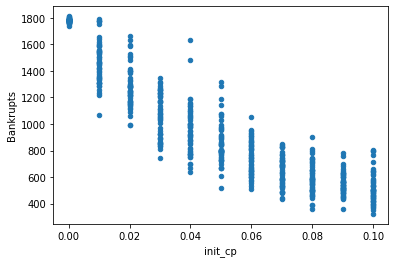

In [15]:
import pandas as pd

df = pd.DataFrame(columns=["init_cp", "Bankrupts"])

for i in range(0,11):
    init_coop = i/100
    bankrupts=batch_model(nsim=50, laststep=40)
    for item in bankrupts:
        df = df.append({"init_cp":init_coop, 'Bankrupts': item}, ignore_index=True)

df.tail()
df.plot.scatter(x='init_cp', y='Bankrupts')



As more schools cooperate at the beginning, less schools go bankrupt overtime. Boxplot can show medium, min and max scenarios from the same data. 

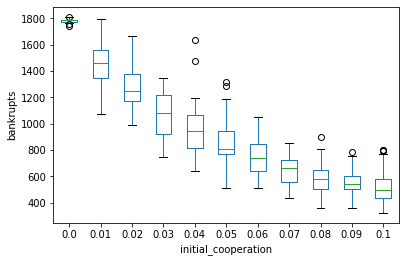

In [16]:
ax = df.boxplot(by ='init_cp', column =['Bankrupts'], grid = False)
plt.title('')
plt.suptitle('')
ax.set_title('')
ax.set_xlabel("initial_cooperation")
ax.set_ylabel("bankrupts")
ax = plt.show()

#### Discussion
- iniital status matter: policy intervention needs to fast work on at the early stage, rather than later when all already broke up. Leader schools (whose scores are higher than others in the model) should show examples to let others imitate.
- what kind of policy intervention: government cannot force institutions to cooperate, but, still, having a few cooperating schools (e.g. 3%) can make some difference. 
- how to interprete the distance among schools: neighbors can mean geographical distance or subject matter of college majors. For example, law schools can together cooperate their number of enrollment.

### To Do
- Web Server Implementation with UI for model parameters
- Cleaning up the code
- Refining the payoff matrix with literature
- Add another imitation rule: 1) the best neighbor (current one) and 2) the most neighbors (behaivor of seeking average)